In [1]:
! pip install catboost


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd

# Prediction X_test

In [3]:
df = pd.read_csv("train-data.csv", sep=";")
month_columns = ['Month 1', 'Month 2', 'Month 3', 'Month 4']
for column in month_columns:
    df[column] = df[column].str.replace(' ', '').astype(float)

In [4]:
df_test = pd.read_csv("X_test.csv", sep=";")
for column in month_columns[:3]:
    df_test[column] = df_test[column].str.replace(' ', '').astype(float)
df_test['Month 4'] = float('nan')

In [5]:
stacked_df = pd.concat([df, df_test])

In [6]:
# new features
stacked_df['Month_4_Mean_Product_Line'] = stacked_df.groupby(['Product  Line proxy', 'Date'])['Month 4'].transform('mean')
stacked_df['Month_4_Mean_Cluster'] = stacked_df.groupby(['Cluster', 'Date'])['Month 4'].transform('mean')
stacked_df['Month_4_Mean_Strategic'] = stacked_df.groupby(['Strategic Product Family proxy', 'Date'])['Month 4'].transform('mean')
stacked_df['Month_4_Mean_Interaction'] = stacked_df.groupby(['Product  Line proxy','Zone', 'Date'])['Month 4'].transform('mean')

In [10]:
stacked_df = stacked_df[['Site','Customer Persona proxy','Month_4_Mean_Product_Line',
       'Month_4_Mean_Cluster', 'Month_4_Mean_Strategic','Month_4_Mean_Interaction',
       'Month 1', 'Month 2', 'Month 3', 'Month 4']]

In [11]:
from catboost import CatBoostRegressor

# Split the data into train and test sets
X = stacked_df.drop('Month 4', axis=1)
y = stacked_df['Month 4']
X_train = X.iloc[:len(df)]
y_train = y.iloc[:len(df)]
X_pred = X.iloc[len(df):]

# Identify the categorical features
categorical_features = ['Site', 'Customer Persona proxy']

# Create the CatBoost model
model = CatBoostRegressor(loss_function='RMSE') # iterations=100, depth=6, learning_rate=0.1, 

# Fit the model on the training data
model.fit(X_train, y_train, cat_features=categorical_features, verbose=False)
y_pred = model.predict(X_pred)

In [12]:
index = df_test['index']
results = pd.DataFrame({'index': index, 'Month 4': y_pred})
results.to_csv('results2.csv', index=False, sep=";")

In [20]:
X.columns

Index(['Site', 'Customer Persona proxy', 'Month_4_Mean_Product_Line',
       'Month_4_Mean_Cluster', 'Month_4_Mean_Strategic',
       'Month_4_Mean_Interaction', 'Month 1', 'Month 2', 'Month 3'],
      dtype='object')

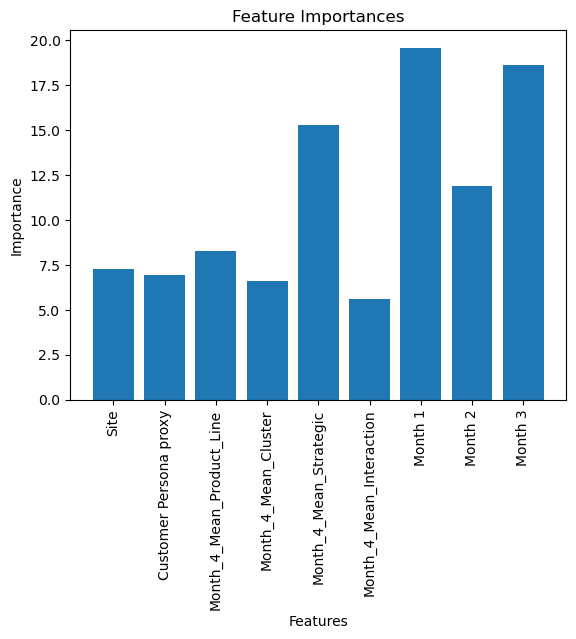

In [22]:
import matplotlib.pyplot as plt
n_features = len(X.columns)
plt.bar(range(n_features), model.feature_importances_,tick_label=X.columns)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()